In [11]:
import json, sys
from pathlib import Path
import pandas as pd
import numpy as np
from typing import Dict
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

# from astropy.constants import G, M_sun
# from astropy import units as u
# from poliastro.iod import izzo
# from poliastro.constants import GM_sun

import warnings
warnings.filterwarnings("ignore")


# Part 1: Parsing 

Here we parse TI json Template files for drives, power plants, etc: `powerplants` df is created, but not saved on the disk

In [12]:
def parse_pplants(data):
    rows = []
    for d in data:
        name = d.get("dataName")
        cls = d.get("powerPlantClass")
        proj = d.get("requiredProjectName")
        eff = d.get("efficiency")
        sp_pow = d.get("specificPower_tGW")

        row = {
            "name": name,
            "class": cls,
            "project": proj,
            "effect": eff,
            "sp_power": sp_pow,
        }
        rows.append(row)

    return pd.DataFrame(rows)

infile = "raw/TIPowerPlantTemplate.json"
outfile = "plants.csv"

infile = Path(infile)
outfile = Path(outfile)
if not infile.exists():
    print("Input file not found:", infile)
    sys.exit(1)
data = json.loads(infile.read_text(encoding='utf-8'))
if isinstance(data, dict):
    for k in ("drives","items","parts","data","templates"):
        if k in data and isinstance(data[k], list):
            data = data[k]
            break
    else:
        data = [data]
plants = parse_pplants(data)
# df.to_csv(outfile, index=False)


plants = plants.drop_duplicates(subset='name').reset_index(drop=True)
# plants.tail(20)

### Drives
`drives` df is created below (see the columns in the cell above)

In [13]:

def parse_drives_json_list(data):
    MATERIAL_KEYS = ["water","volatiles","metals","nobleMetals","fissiles","antimatter"]
    rows = []
    for d in data:
        name = d.get("friendlyName")
        cls = d.get("driveClassification")
        proj = d.get("requiredProjectName")
        thrust = d.get("thrust_N")
        ev = d.get("EV_kps")
        specific_power = d.get("specificPower_kgMW")
        # print(d['specificPower_kgMW'])
        eff = d.get("efficiency")
        flat_mass = d.get("flatMass_tons")
        req_power_plant = d.get("requiredPowerPlant")
        thrust_cap = d.get("thrustCap")
        cooling = d.get("cooling")
        propellant = d.get("propellant")
        mats = d.get("perTankPropellantMaterials") or d.get("per_tank_propellant_materials") or {}
        material_values = {k:0 for k in MATERIAL_KEYS}
        if isinstance(mats, dict):
            for k,v in mats.items():
                key_norm = k.strip()
                for canonical in MATERIAL_KEYS:
                    if key_norm.lower() == canonical.lower() or key_norm.replace("_","").lower() == canonical.lower():
                        try:
                            material_values[canonical] = float(v)
                        except:
                            material_values[canonical] = v
                        break

        row = {
            "name": name[:-2],
            "class": cls,
            "project": proj,
            "thrust": thrust,
            "EV": ev,
            "specific_power": specific_power,
            "effect": eff,
            "flat_mass": flat_mass,
            "required_power_plant": req_power_plant,
            "thrust_cap": thrust_cap,
            "cooling": cooling,
            "propellant": propellant
        }
        row.update(material_values)
        rows.append(row)

    return pd.DataFrame(rows)

infile = "raw/TIDriveTemplate.json"
outfile = "drives.csv"

infile = Path(infile)
outfile = Path(outfile)
if not infile.exists():
    print("Input file not found:", infile)
    sys.exit(1)
data = json.loads(infile.read_text(encoding='utf-8'))
if isinstance(data, dict):
    for k in ("drives","items","parts","data","templates"):
        if k in data and isinstance(data[k], list):
            data = data[k]
            break
    else:
        data = [data]
drives = parse_drives_json_list(data)
# drives.to_csv(outfile, index=False)


drives = drives.drop_duplicates(subset='name').reset_index(drop=True)
drives['fissiles'][drives['name'].str.contains('Helion', case=False)] = 0

mask = (~drives['class'].str.contains('pulse', case=False))
drives.loc[mask, 'thrust'] = drives.loc[mask, 'thrust']*6
drives.loc[mask, 'flat_mass'] = drives.loc[mask, 'flat_mass']*6


# mask = (drives['name'].str.contains('converter', case=False))
# drives.loc[mask, 'thrust'] = drives.loc[mask, 'thrust']/2
# drives.loc[mask, 'flat_mass'] = drives.loc[mask, 'flat_mass']/2

# mask = (drives['name'].str.contains('pion', case=False))
# drives.loc[mask, 'thrust'] = drives.loc[mask, 'thrust']/2
# drives.loc[mask, 'flat_mass'] = drives.loc[mask, 'flat_mass']/2

drives['power'] = drives['thrust']*drives['EV']/2000000/drives['effect']

# drives.tail(15)


### Alien ships
In the cell below we parse the save file for alien ships -- we gonna need that later for intercept calculations. Only 3 columns are stored: current cruise acceleration, current and max dv.

In [14]:
def extract_alien(path):
    data = json.loads(open(path, "r", encoding="utf-8").read())

    rows = []
    stack = [data]

    while stack:
        obj = stack.pop()

        if isinstance(obj, dict):

            if (
                "cruiseAcceleration_mps2" in obj and
                "currentDeltaV_kps" in obj and
                "currentMaxDeltaV_kps" in obj
            ):
                alien = False

                if "ammo" in obj:
                    for entry in obj.get("ammo", []):
                        k = entry.get("Key", {})
                        name = k.get("moduleTemplateName", "")
                        if isinstance(name, str) and "Alien" in name:
                            alien = True
                            break

                if not alien:
                    sub = [obj]
                    while sub and not alien:
                        cur = sub.pop()
                        if isinstance(cur, dict):
                            for v in cur.values():
                                if isinstance(v, (dict, list)):
                                    sub.append(v)
                                elif isinstance(v, str) and "Alien" in v:
                                    alien = True
                                    break
                        elif isinstance(cur, list):
                            for v in cur:
                                if isinstance(v, (dict, list)):
                                    sub.append(v)
                                elif isinstance(v, str) and "Alien" in v:
                                    alien = True
                                    break

                if alien:
                    rows.append({
                        "cruise_accel": obj["cruiseAcceleration_mps2"],
                        "dv_current": obj["currentDeltaV_kps"],
                        "dv_max": obj["currentMaxDeltaV_kps"],
                    })
                continue

            for v in obj.values():
                if isinstance(v, (dict, list)):
                    stack.append(v)

        elif isinstance(obj, list):
            for v in obj:
                if isinstance(v, (dict, list)):
                    stack.append(v)

    return pd.DataFrame(rows)

aliens = extract_alien("raw/late_save.json")

### Research
In this and the next cell we are parsing the Project and Tech templates for the Research Points, required for each drive/plant. We are going to need that to apply stats to our actual "ship" (which the given drive will be attached to), based on the game stage. I.e. early game drives will use lighter frame, but less advanced radiators, etc

In [18]:
project_data = json.loads(Path("raw/TIProjectTemplate.json").read_text(encoding="utf-8"))
tech_data     = json.loads(Path("raw/TITechTemplate.json").read_text(encoding="utf-8"))

project_dict = {d["dataName"]: d for d in project_data}
tech_dict     = {d["dataName"]: d for d in tech_data}

In [19]:
project_data = json.loads(Path("raw/TIProjectTemplate.json").read_text(encoding="utf-8"))
tech_data    = json.loads(Path("raw/TITechTemplate.json").read_text(encoding="utf-8"))

project_dict = {d["dataName"]: d for d in project_data}
tech_dict    = {d["dataName"]: d for d in tech_data}

all_nodes = {**project_dict, **tech_dict}

prereq_graph  = {}
forward_graph = defaultdict(list)

for name, node in all_nodes.items():
    prereqs = node.get("prereqs", [])
    prereq_graph[name] = prereqs
    for p in prereqs:
        forward_graph[p].append(name)

# compute out-degree
out_degree = {n: len(forward_graph.get(n, [])) for n in all_nodes}

# graph travers
def total_research_cost(root_name, visited=None):
    if visited is None:
        visited = set()
    if root_name in visited:
        return 0
    visited.add(root_name)
    node = all_nodes.get(root_name)
    if not node:
        return 0
    cost = node.get("researchCost", 0)
    for p in prereq_graph.get(root_name, []):
        cost += total_research_cost(p, visited)
    return cost

def marginal_research_cost(root_name, cutoff=3, weight_mode=False, visited=None):
    """Same as total_research_cost but prunes or weights nodes with high out-degree"""
    if visited is None:
        visited = set()
    if root_name in visited:
        return 0
    visited.add(root_name)
    node = all_nodes.get(root_name)
    if not node:
        return 0
    deg = out_degree.get(root_name, 0)
    base_cost = node.get("researchCost", 0)
    if deg > cutoff:
        if weight_mode:
            # inverse weight
            base_cost /= (deg + 1)
        else:
            base_cost = 0
    total = base_cost
    for p in prereq_graph.get(root_name, []):
        total += marginal_research_cost(p, cutoff=cutoff, weight_mode=weight_mode, visited=visited)
    return total

results_raw = []
results_pruned = []

for project_name in drives['project']:
    if not project_name:
        results_raw.append(0)
        results_pruned.append(0)
        continue
    results_raw.append(total_research_cost(project_name))
    results_pruned.append(marginal_research_cost(project_name, cutoff=4, weight_mode=True))

drives['RP_raw'] = np.array(results_raw)
drives['RP_focus'] = np.array(results_pruned, dtype=int)
drives.loc[drives['project']=='Project_HelionNovaTorch',['RP_raw','RP_focus']] = drives.loc[drives['project']=='Project_BoraneNovaLantern',['RP_raw','RP_focus']].values

results = []
for d in plants['project']:
    project_name = d
    if not project_name:
        total_cost = 1
    else:
        total_cost = total_research_cost(project_name)
    results.append(total_cost)

plants['Research'] = np.asarray(results)
# plants.sort_values(by='Research').head(20)


I actually went a little over the top here, and not only searched for techs within the given research branch (that is `RP_raw` -- basically, the cost of ALL the techs, required to build a given drive). I also decided to isolate only the projects, which lead to that specific drive/plant, but not something else (that would be `RP_focus`). I.e. the **ICF drives** all require `Arc Lasers` tech -- but you're gonna research Arc Lasers anyway, so why would you count it, right? But on the other hand, there's plenty of stuff that you gonna have to research specifically for that given drive family alone (e.g. `Antimatter Propulsion`), and it's useless for everything else. Basically that was a measure of your "commitment" to the given drive or drive family.

But turns out, this part was useless in the end. At least I haven't figured how to display it in an informative way.

In [20]:
# def collect_branch_nodes(root_name, visited=None):
#     """Return all nodes reachable via prereqs from root_name."""
#     if visited is None:
#         visited = set()
#     if root_name in visited:
#         return visited
#     visited.add(root_name)
#     for p in prereq_graph.get(root_name, []):
#         collect_branch_nodes(p, visited)
#     return visited

# def analyze_cutoffs(sample_name, cutoffs=(0,1,2,3,5,10), weight_mode=False):
#     """Display how cost changes for various cutoff thresholds for one branch."""
#     print(f"=== {sample_name} ===")
#     base = total_research_cost(sample_name)
#     print(f"Full cost: {base:,.0f}")
#     for c in cutoffs:
#         mc = marginal_research_cost(sample_name, cutoff=c, weight_mode=weight_mode)
#         print(f"cutoff={c:>2}  →  marginal cost={mc:,.0f}  (ratio={mc/base:.2f})")

#     branch_nodes = collect_branch_nodes(sample_name)
#     branch_degrees = [(n, out_degree.get(n, 0)) for n in branch_nodes]
#     branch_degrees.sort(key=lambda x: x[1], reverse=True)

#     print("\nNodes within this branch sorted by out-degree:")
#     for n, deg in branch_degrees:
#         label = ""
#         print(f"{deg:>3}  {n} {label}")

# # project name
# analyze_cutoffs("Project_HeliconDrive", cutoffs=(0,1,2,3,4,5), weight_mode=True)


# Part 2: Splitting drives into different Game Stages 

This part (and the following one) is super-important. The main idea here: you'll be prefering different drives at different stages of the game. And, naturally, you'll have differnt toys to play with, and vastly different resources at hand. 

Therefore, we sort drives into Research Point bins and apply ship templates to our drives. And also a bunch of stuff that is supposed to buff certain drive families -- e.g. Antimatter Spiker or Hydron Trap for hydro drives.

In [21]:
rads = np.asarray([153.8, 125, 100, 76.9, 41.7])
hull = np.asarray([2500, 6500, 12000, 20000, 35000])
hydro = np.asarray([1.2, 1.35, 1.5])
spike = np.asarray([1.1, 1.2, 1.3])
# spike = np.asarray([1., 1., 1.])

bins = [1e3,2e4,1e5,2.97e5,7e5]

drives['RP_bins'] = 0
drives.loc[drives['RP_raw']<bins[1],'RP_bins'] = 1
drives.loc[(drives['RP_raw']>bins[1])&(drives['RP_raw']<bins[2]),'RP_bins'] = 2
drives.loc[(drives['RP_raw']>bins[2])&(drives['RP_raw']<bins[3]),'RP_bins'] = 3
drives.loc[(drives['RP_raw']>bins[3])&(drives['RP_raw']<bins[4]),'RP_bins'] = 4
drives.loc[drives['RP_raw']>bins[4],'RP_bins'] = 5
drives.loc[drives['RP_raw']<0, 'RP_bins'] = 5

mask_high = drives['class'].isin(['Fission_Thermal', 'Fusion_Thermal']) & drives['RP_bins'].isin([4,5])
drives.loc[mask_high, 'thrust'] = drives.loc[mask_high, 'thrust'] * spike[2]

mask_fission_med = (drives['class'] == 'Fission_Thermal') & drives['RP_bins'].isin([2,3])
drives.loc[mask_fission_med, 'thrust'] = drives.loc[mask_fission_med, 'thrust'] * spike[1]

mask_fusion_med = (drives['class'] == 'Fusion_Thermal') & drives['RP_bins'].isin([2,3])
drives.loc[mask_fusion_med, 'thrust'] = drives.loc[mask_fusion_med, 'thrust'] * spike[0]

mask_hydrogen = drives['propellant'].str.lower() == 'hydrogen'

mask_h1 = mask_hydrogen & (drives['RP_bins'] == 1)
drives.loc[mask_h1, 'EV'] = drives.loc[mask_h1, 'EV'] * hydro[0]

mask_h23 = mask_hydrogen & drives['RP_bins'].isin([2,3])
drives.loc[mask_h23, 'EV'] = drives.loc[mask_h23, 'EV'] * hydro[1]

mask_h45 = mask_hydrogen & drives['RP_bins'].isin([4,5])
drives.loc[mask_h45, 'EV'] = drives.loc[mask_h45, 'EV'] * hydro[2]

### Resource check

Super-important stuff here:
1. We are going to parse the templates for all the celestial bodies and store the names and semi-major axis (SMA) in df
2. Then we gonna parse all the mines and store into a df the resrouces that they produce (1 row per mining site), and then use the name of the space body to attach the SMA to those mining sites.

In [238]:
#------------------------------------------------------------------------------------------------------------------------------------------------
path = Path("raw/TISpaceBodyTemplate.json")

with path.open("r", encoding="utf-8") as f:
    data = json.load(f)

rows = []
for obj in data:
    name = obj.get("dataName")
    sma  = obj.get("semiMajorAxis_AU")
    bcent = obj.get("barycenterName")

    rows.append((name, sma, bcent))

df_bodies = pd.DataFrame(rows, columns=["dataName", "semiMajorAxis_AU", "bcent"])

for bar in df_bodies['bcent'].unique():
    if bar and bar != 'Sol':
        mask1 = (df_bodies['bcent'] == bar)
        mask2 = df_bodies['dataName'] == bar
        x = df_bodies.loc[mask2,'semiMajorAxis_AU'].values[0]
        df_bodies.loc[mask1] = df_bodies[mask1].fillna(x) 

df_bodies.dropna(inplace=True)
# df_bodies.head(3)

#------------------------------------------------------------------------------------------------------------------------------------------------

RESOURCE_KEYS = ["water_day","volatiles_day","metals_day","nobles_day","fissiles_day"]
CANONICAL = ["water","volatiles","metals","nobleMetals","fissiles"]

def load_json_fast(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

def scan_sites_from_loaded_json(data):
    sites = []
    def recurse(obj):
        if isinstance(obj, dict):
            # direct match: object that contains the resource keys
            if any(k in obj for k in RESOURCE_KEYS):
                sites.append(obj)
                return
            if "Value" in obj and isinstance(obj["Value"], dict) and any(k in obj["Value"] for k in RESOURCE_KEYS):
                sites.append(obj["Value"])
                return
            for v in obj.values():
                recurse(v)
        elif isinstance(obj, list):
            for item in obj:
                recurse(item)
    recurse(data)
    return sites

p = Path('raw/save.json')
data = load_json_fast(p)
sites = scan_sites_from_loaded_json(data)


sma_map = dict(zip(df_bodies["dataName"], df_bodies["semiMajorAxis_AU"]))

rows = []
for s in sites:
    tname = s.get("templateName", "")
    body = tname.split("Site")[0]     # "MercurySite1" → "Mercury"
    sma  = sma_map.get(body, None)

    # normalize noble metals exactly once
    nobles = s.get("nobles_day")
    if nobles is None:
        nobles = s.get("nobleMetals_day")
    if nobles is None:
        nobles = s.get("noble_day")
    if nobles is None:
        nobles = 0.0

    rows.append({
        "sma": sma,
        "water_day":       float(s.get("water_day", 0.0) or 0.0),
        "volatiles_day":   float(s.get("volatiles_day", 0.0) or 0.0),
        "metals_day":      float(s.get("metals_day", 0.0) or 0.0),
        "nobles_day":      float(nobles or 0.0),
        "fissiles_day":    float(s.get("fissiles_day", 0.0) or 0.0),
    })

df_sites = pd.DataFrame(rows)
df_sites


,sma,water_day,volatiles_day,metals_day,nobles_day,fissiles_day
0,0.387099,0.179841,0.093494,1.781668,0.194002,0.005214
1,0.387099,0.069749,0.155692,1.213284,0.331980,0.004412
2,0.387099,0.000983,0.152816,1.717705,0.000000,0.006673
3,0.387099,0.071559,0.408250,1.779043,0.259448,0.025381
4,0.387099,0.000000,0.133124,1.401482,0.198854,0.023216
...,...,...,...,...,...,...
556,3.064830,1.587703,0.927949,0.052332,0.000000,0.000000
557,17.184573,1.943041,1.146181,0.000000,0.000000,0.000000
558,3.562596,1.852187,0.147627,0.000000,0.000000,0.000000
559,3.035034,1.406388,0.209269,0.000000,0.000000,0.000000


Above you can see the resulting `df_sites` df

### Calculating max number of tanks, allowed for a given drive, based on resource scarcity:

And this is where shit gets real tricky:

You see, during the game you won't have an access to all the resources immediately (or sometimes at all). Some resources are more rare than others, some resources are only available at certain space bodies (which require you to be at certain stage in the game).

Therefore, you will have certain limitations with drives that use rare resources. E.g. Neutron Flux rockets. Our goal here is to estimate what resources are available to you at what stage in the game, and base on that how many propellant tanks you can afford to your ships.

The cell below does that as follows:
1. It checks the available mines in the distance that you can reach, based on the game stage
2. Checks the contents of the given drive's prop tank
3. Picks a resource, which you need for the prop tank
4. Sorts for the best available mines for the given resource
5. Picks ONE mine from that list
6. Check how many prop tanks it can build NOW
7. Selects the most desperately needed resource based on 6)
8. Goes back to step 4 -- until you run out of mines that you can sustain

In [234]:
full_refil = np.logspace(np.log10(0.5), np.log10(5), num=5) # number of ships we NEED to refill each month
n_mines = [8,12,20,28,36] # number of mines allowed per each stage of the game

sma_bins = [   # semi-major axis bins for mines 
    [0.5,  2.], # Earth and Mars + close asteroids
    [0.5, 4.1], # Earth, Mars, Belt, but not Mercury
    [0.,  5.2], # everything up to Jupiter
    [0.,   12], # Saturn and stuff
    [0., 100.]  # whole Sol System
]
mining_eff = [1., 1.5*1.1, 1.5*1.5, 2*2, 2*2.5]

drives['tank_cap'] = np.zeros(len(drives))

ks = drives.index
for k in ks:
# print(drives.loc[k,'name'])
    RP_bin = drives.loc[k,'RP_bins'] - 1
    mask = (df_sites['sma']>sma_bins[RP_bin][0]) & (df_sites['sma']<sma_bins[RP_bin][1]) # pick viable mining sites for given stage of the game

    tank = (drives.loc[k,['water','volatiles','metals','nobleMetals','fissiles']])
    am = np.asarray([30,30,20,20,10])*10*drives.loc[k,'antimatter']
    tank = tank+am
    am_penalty = tank.sum()
    tank = tank/am_penalty

    totals = np.zeros(5)
    mine_counter = np.zeros(len(RESOURCE_KEYS),dtype=int)
    if am_penalty>1.001:
        i = -1
    else:
        i = 0

    for j in range(n_mines[RP_bin]):
        top_mines_for_res = df_sites.loc[mask,RESOURCE_KEYS].sort_values(by=RESOURCE_KEYS[i], ascending=False) # pick best mines for a given resource
        totals = totals + top_mines_for_res.iloc[mine_counter[i]] # add it to totals
        mine_counter[i] += 1 # iterate mine counter so we don't pick the same sites again
        # print(totals/(tank).values)
        # print()
        i = (totals/(tank).values).argmin() # calculate the available tanks, select the most scarce resource

    # -- min value here will be our max number of tanks allowed per ship (200 means no resource limit, but we probably don't want more than that anyways)
    drives.loc[k,'tank_cap'] = min(200,(totals*30*mining_eff[RP_bin] / (tank*10).values / full_refil[RP_bin] / am_penalty).min())

Basically, the cell above optimizes the best mine composition for your fleet.

In [241]:
mine_counter

array([1, 0, 7, 0, 0])

### Powerplants

In the cell below we marry our powerplants to drives. We just pick the plant that is closest to the given drive by RP points. Usually the drive project comes immediately after the specific power plant, so the process is fairly determenistic. However there are some notable exceptions -- e.g. Daedalus Torch begs for a better ICF plant, otherwise you're gonna pay way too much for heavy radiators.

In [242]:
def match_powerplants(drives, plants):
    drives = drives.copy()
    plants = plants.copy()
    drives['required_power_plant'] = drives['required_power_plant'].fillna("Any_General")
    plants['class'] = plants['class'].fillna("Unknown")

    plants_sorted = plants.sort_values(by='Research').reset_index(drop=True)

    matched_effects = []
    matched_sp = []

    for _, drv in drives.iterrows():
        plant_family = drv['required_power_plant']
        drv_research = drv.get('RP_raw', np.nan)

        if plant_family != "Any_General" and plant_family in plants_sorted['class'].values:
            fam_plants = plants_sorted[plants_sorted['class'] == plant_family]
        else:
            fam_plants = plants_sorted

        if not np.isnan(drv_research):
            fam_plants = fam_plants.assign(diff=np.abs(fam_plants['Research'] - drv_research))
            best = fam_plants.loc[fam_plants['diff'].idxmin()]
        else:
            best = fam_plants.iloc[-1]

        matched_effects.append(best['effect'])
        matched_sp.append(best['sp_power'])

    drives['plant_effect'] = matched_effects
    drives['plant_sp_power'] = matched_sp
    return drives

drives_with_plants = match_powerplants(drives, plants)
drives = drives_with_plants
# drives.tail(15)


### Dry mass
In this cell we calculate dry mass (all equipment/armor installed, but no propellant) for a ship with a given drive. See the templates above for the actual values.

In [243]:
drives['dry_mass'] = drives['flat_mass'] + drives['power']*drives['specific_power']

mask1 = (drives['dry_mass']==0)
mask2 = (drives['cooling']!='Open')

for i in range(len(rads)):
    a = i + 1

    mask3 = (drives['RP_bins'] == a)
    
    plat_mass = drives['plant_sp_power']*drives['power']
    rads_mass = rads[i]*((1-drives['plant_effect'])*drives['power'])

    drives.loc[mask3, 'dry_mass'] = drives.loc[mask3, 'dry_mass'] + hull[i]
    drives.loc[mask1&mask3, 'dry_mass'] = drives.loc[mask1&mask3, 'dry_mass'] + plat_mass[mask1&mask3]
    drives.loc[mask2&mask3, 'dry_mass'] = drives.loc[mask2&mask3, 'dry_mass'] + rads_mass[mask2&mask3]



drives['dry_mass'].iloc[18]


6751.59746835443

Here we calculate DV and combat/cruise accel. Just to store it in the dataset.

In [244]:
prop_mass = 5000

m0 = drives['dry_mass'] + prop_mass
mf = drives['dry_mass']
ve = drives['EV'] * 1000

drives['accel'] = drives['thrust'] / (m0 * 1000) 
drives['comb_ac'] = drives['thrust_cap']*drives['accel']/9.8 # gees
drives['DV'] = ve * np.log(m0 / mf) / 1000

### Drive classes
In this cell we rewrite the drive classes to be more specific. I.e. instead of being simply "Fusion Thermal" we now can tell what kind of fusion is that. We gonna need it later for graphs.

In [245]:
cls = drives['required_power_plant'].copy()
mask = (cls=='Any_General')
cls.loc[mask] = drives.loc[mask,'class'].copy()

cls.loc[cls.str.contains('Core_Fission')] = cls.loc[cls.str.contains('Core_Fission')].str.rstrip('_Fission')
cls.loc[cls.str.contains('_Fusion')] = cls.loc[cls.str.contains('_Fusion')].str.rstrip('_Fusion')
cls.loc[cls.str.contains('Antimatter')] = 'Antimatter'

drives['class'] = cls
cls.unique()

array(['Chemical', 'Electrothermal', 'Electrostatic', 'Electromagnetic',
       'Solid_Core', 'Liquid_Core', 'Gas_Core', 'NuclearSaltWater',
       'Fission_Pulse', 'Electrostatic_Confinement',
       'Mirrored_Magnetic_Confinement', 'Toroid_Magnetic_Confinement',
       'Hybrid_Confinement', 'Z_Pinch', 'Inertial_Confinement',
       'Antimatter'], dtype=object)

In [246]:
# drives[drives['name'].str.contains('orio',case=False)]

In [247]:
# drives[drives['name'].str.contains('poly',case=False)]

### Store df
display the df and store it:

In [248]:
# mask = (drives['power']==0)
out_path = "drives.csv"
drives.to_csv(out_path)
drives.loc[:, ['name', 'thrust', 'EV', 'class', 'power','specific_power','flat_mass','plant_sp_power','cooling','RP_bins', 'dry_mass', 'accel', 'comb_ac', 'DV','tank_cap']].tail(20)

,name,thrust,EV,class,power,specific_power,flat_mass,plant_sp_power,cooling,RP_bins,dry_mass,accel,comb_ac,DV,tank_cap
76,Zeta Deuteron Torch,5616000.0,3334.00,Z_Pinch,7580.463158,0.0,0,0.00680,Closed,5,36632.073718,0.134896,0.825894,426.574249,200.000000
77,Zeta Helion Lantern,4680000.0,1335.00,Z_Pinch,2503.125000,0.0,0,0.40000,Closed,4,24851.056250,0.156778,0.959868,244.732157,200.000000
78,Zeta Borane Lantern,3244800.0,3077.00,Z_Pinch,3958.861856,0.0,0,0.40000,Closed,5,39885.235530,0.072291,0.442598,363.401983,200.000000
79,Triton Nova Drive,2770560.0,405.00,Inertial_Confinement,359.640000,0.0,0,3.00000,Closed,4,24121.114760,0.095139,0.291242,76.292246,200.000000
80,Deuteron Nova Lantern,3276000.0,858.00,Inertial_Confinement,847.905882,0.0,0,2.00000,Closed,4,26912.128753,0.102657,0.523760,146.210992,200.000000
81,Helion Nova Lantern,14820000.0,790.50,Inertial_Confinement,3162.000000,0.0,0,1.00000,Closed,4,35319.890000,0.367561,1.875309,104.661120,200.000000
82,Helion Nova Torch,5171400.0,13815.00,Inertial_Confinement,19081.968750,0.0,0,0.06800,Closed,5,44254.754844,0.104993,0.749949,1478.800264,200.000000
83,Borane Nova Lantern,20824050.0,1017.00,Inertial_Confinement,5485.122727,0.0,0,0.06800,Closed,5,37660.284523,0.488137,2.988592,126.781563,200.000000
84,Protium Nova Torch,51480000.0,1500.00,Inertial_Confinement,20412.371134,0.0,0,0.06800,Closed,5,44900.000000,1.031663,6.316306,158.374812,200.000000
85,Protium Converter Torch,76128000.0,10256.00,Inertial_Confinement,306424.163265,0.0,0,0.00200,Closed,5,48390.735935,1.425865,8.729788,1008.460762,200.000000


# Part 3: Actual Calculations

Below is a function that we gonna use for calculating transfer times. Input parameters are orbital radii for the start and the finish, exhaust velocity of the drive, dry mass, drive thrust, dt and max t.

In [249]:
GM = 1.32712440018e20   # Sun GM

def transfer_time(r1, r2, ve, m_dry, T, mp0, dt=3600.0, max_days=3000):
    # orbital circular velocities
    v1 = np.sqrt(GM/r1)
    v2 = np.sqrt(GM/r2)

    # total dv from rocket eq
    dv_tot = ve * np.log((m_dry+mp0)/m_dry)

    # dv split
    dv_acc  = 0.5*(dv_tot + (v1 - v2))
    dv_brk  = 0.5*(dv_tot - (v1 - v2))
    if dv_acc<0 or dv_brk<0:
        return -1

    # mass flow
    mdot = T/ve

    # forward craft (from r1)
    r_f  = np.array([r1,0.0])
    v_f  = np.array([0.0, v1])
    m_f  = m_dry + mp0 # full tank
    dv_f = 0.0

    # backward craft (from r2)
    r_b  = np.array([0.,r2])
    v_b  = np.array([-v2, 0.])
    m_b  = m_dry # empty tank
    dv_b = dv_brk

    t = 0.0
    max_t = max_days*86400.0

    # rb_list = []
    # rf_list = []
    while t < max_t:
        # radii
        rf = np.linalg.norm(r_f)
        rb = np.linalg.norm(r_b)

        # meet condition
        if rf > rb:
            return 2*t/86400.0/7.

        # FORWARD craft
        if dv_f < dv_acc and m_f > m_b:
            a_th_f = (T/m_f)*(r_f/rf)
            m_f -= mdot*dt
            dv_f += np.linalg.norm((T/m_f)*dt)
        else:
            a_th_f = 0.0*(r_f)

        a_gr_f = -GM*r_f/(rf**3)
        v_f += (a_th_f + a_gr_f)*dt
        r_f += v_f*dt

        # BACKWARD craft
        if dv_b > 0 and m_b < m_f:
            a_th_b = -(T/m_b)*(r_b/rb)
            m_b += mdot*dt
            dv_b -= np.linalg.norm((T/m_b)*dt)
        else:
            a_th_b = 0.0*(r_b)

        a_gr_b = -GM*r_b/(rb**3)
        v_b += (a_th_b + a_gr_b)*dt
        r_b += v_b*dt

        t += dt
        # rb_list.append(rb/au)
        # rf_list.append(rf/au)
    return -1


This cell was probably the hardest part of the analysis, because initially I started searching in the wrong place, by trying to replicate Lambert Solver.

Turns out, good old 2D Euler can do the trick just as well. Here we solve standard 2-body problem with variable mass. We start at orbital radius r1 around the Sun, and try to move outwards from the Sun to the radius r2. We start with the initial velocity, equal to the orbital velocity at that radius, then we accelerate in tangential direction. The tricky part: we need to save some fuel to decelerate. Especially considering, that r2 is going to have diffferent orbital velocity, and we gonna have to match that.

So, the main question: WHEN do we flip and burn?

The answer is: you don't have to think about it, because you can just launch a "mirror" ship from the orbit r2 towards our "actual" ship. This ship is ALSO gonna spend DV to accelerate towards the first. Except, unlike the actual real ship, our mirror "ghost" ship is gonna start at dry mass, and then gonna GAIN mass as it accelerates. Which emulates the phase when the actual ship will be decelerating.

If the "ships" run out of their respective DV limits -- that's where the drift phase is on. The end condition is when the orbital radii of both ship cross. Then we just return 2*t.

The solver's is fairly pricise. For torch drives the error (compared to in-game values) is usually within 5-10%. For low thrust drives (spiral or hoffman trajectory) it might be around 20-30% -- because in that case the time will depend on the actual ephemerides of the celestial bodies.

In [250]:
# drives[drives['name'].str.contains('ion',case=False)]

Solver test on Pion Torch with 100 tanks:

In [251]:
au = 1.496e8 * 1e3

k = 92

ve = drives.loc[k,'EV']*1e3
m_dry = drives.loc[k,'dry_mass']*1e3
T = drives.loc[k,'thrust']

r1 = 1.*au
r2 = 5.2*au

ve = drives.loc[k,'EV']*1e3
m_dry = drives.loc[k,'dry_mass']*1e3
T = drives.loc[k,'thrust']

pm = 100
mp0 = pm*1e5

print(drives.loc[k,'name'], drives.loc[k,'dry_mass'])
transfer_time(r1,r2,ve,m_dry,T,mp0,dt=3600.0)

Pion Torch  35008.8496993988


2.130952380952381

Here we keep testing the solver on different drives. Now we input variable propellant mass. Initially by "variable" I simply meant that we calculate the transfer time for an array of prop tanks between 1 and 200, spaced equidistantly in log space. But then I figured out that this might be fair for late-game drives, but for the early game -- probably not so much. There's no way you gonna dump 200 tanks on average on an Apex Solid Rocket. You can't afford that.
Therefore, the propellant tanks are actually capped based on the game stage and on the resources available at that stage **(see the calculations above)**

And as a result -- you can see beautiful logarithmic curves (dictated by the all-powerful rocket equation) for transfer times vs propellant tanks spent. 

The question is: how would you measure **which drive is faster in general?**

The answer: we're gonna average it for all propellant tanks by integrating. Basically, the lesser is the area under the curve, the faster the drive is in general.

Text(0, 0.5, 'Travel time (weeks, log10)')

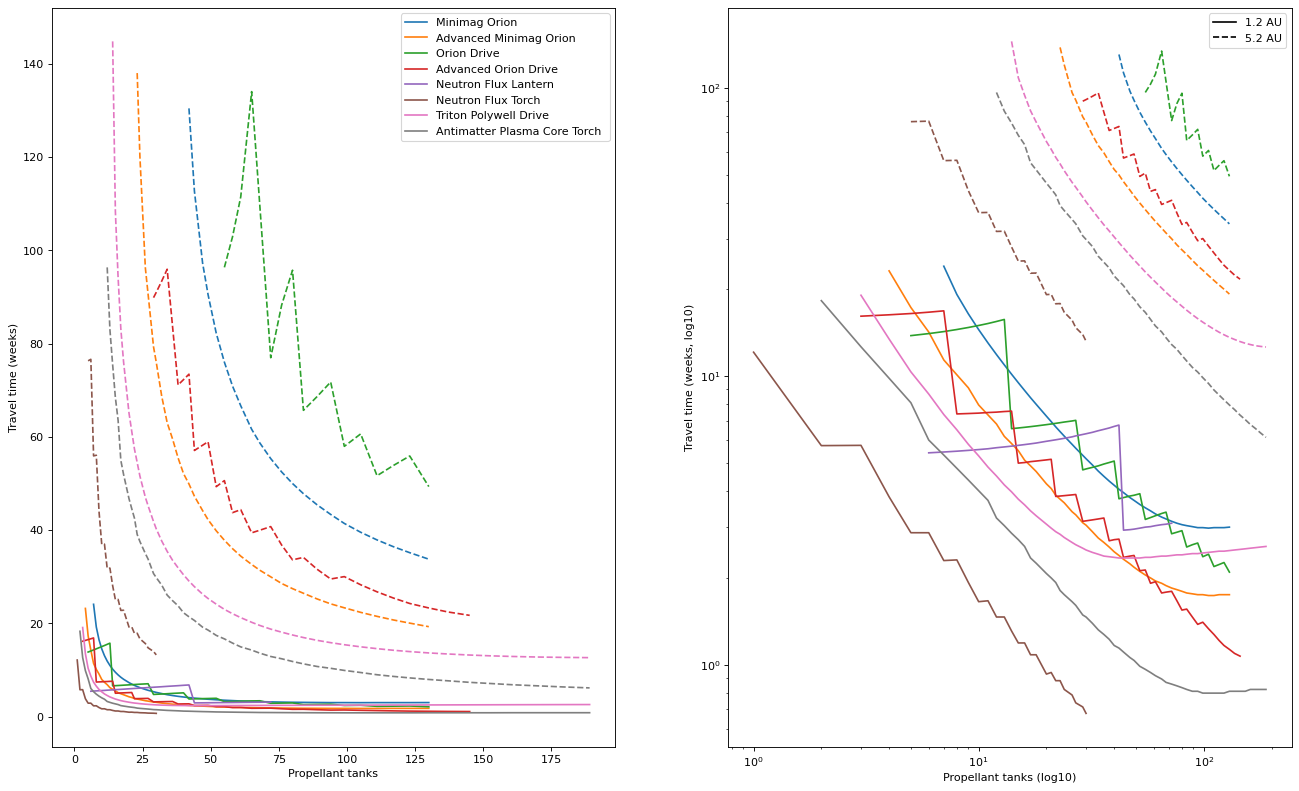

In [258]:
from matplotlib.lines import Line2D

figure(figsize=(20, 12), dpi=80)

au = 1.496e8 * 1e3
ks  = [56,57,58,59,51,52,70,90]
col = ['C0','C1','C2','C3','C4','C5','C6','C7']
js  = [0,1]
lines = ['-','--']

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

for j in js:
    kk=0
    r1 = 1.*au
    r2 = (4*j+1.2)*au

    for k in ks:
        ve = drives.loc[k,'EV']*1e3
        m_dry = drives.loc[k,'dry_mass']*1e3
        T = drives.loc[k,'thrust']

        prop_cap = drives.loc[k,'tank_cap']
        rb = drives.loc[k,'RP_bins'] - 1
        pms = np.unique((10**np.linspace(0,np.log10(200),num=100)).astype(int))
        pms = pms[pms<prop_cap]
        tts = np.zeros(len(pms))

        for i in range(len(tts)):
            mp0 = pms[i]*1e5
            tts[i] = transfer_time(r1,r2,ve,m_dry,T,mp0)

        if j==0:
            ax1.plot(pms[tts>0], tts[tts>0],
                     label=drives.loc[k,'name'],
                     ls=lines[j], c=col[kk])
            ax2.loglog(pms[tts>0], tts[tts>0],
                       label=drives.loc[k,'name'],
                       ls=lines[j], c=col[kk])
        else:
            ax1.plot(pms[tts>0], tts[tts>0],
                     ls=lines[j], c=col[kk])
            ax2.loglog(pms[tts>0], tts[tts>0],
                       ls=lines[j], c=col[kk])
        kk+=1

leg1 = ax1.legend(loc='upper right')

handles2 = [
    Line2D([0],[0], color='k', ls='-',  label='1.2 AU'),
    Line2D([0],[0], color='k', ls='--', label='5.2 AU'),
]
ax2.legend(handles=handles2, loc='upper right')

ax1.set_xlabel('Propellant tanks')
ax1.set_ylabel('Travel time (weeks)')

ax2.set_xlabel('Propellant tanks (log10)')
ax2.set_ylabel('Travel time (weeks, log10)')



# Part 4: Velocity and Range calculations

Here we gonna use stored pre-calculated arrays `t_R.npy` and `p_R.npy`. Those are respectively:
1. the transfer time for a given orbital radius (radius varies between 1AU and 30AU), averaged over the propellant tanks spent
2. propellant tanks, required for THIS particular transfer time

These values are calculated inside `get_times.py` script as follows:\
`expect_t = np.trapz(t_good, p_good) / (p_good.max() - p_good.min())`\
`expect_p = p_good[np.argmin(np.abs(t_good - expect_t))]`

In [259]:
# figure(figsize=(20, 12), dpi=80)
# ax1 = plt.subplot(1,2,1)
# ax2 = plt.subplot(1,2,2)


# ks  = [78,83,84,85,91]
# R = 10**np.linspace(0,np.log10(30),num=31)[1:]


# t_R = np.load('t_R.npy')
# for k in ks:
#     t_row = t_R[k]
#     ax1.plot(t_row, R, label=drives.loc[k,'name'])
#     ax2.plot(R, R/t_row, label=drives.loc[k,'name'])

# ax1.legend(loc='lower right')
# ax1.set_xlabel('Travel time (weeks)')
# ax1.set_ylabel('Orbit radius (AU)')
# ax2.set_ylabel('Speed (AU/week)')
# ax2.set_xlabel('Orbit radius (AU)')

And here we plot:
1. the orbital radius in AU vs time in weeks (**left**), which takes for the given drive to reach that radius from 1AU. 
2. which leads us to "speed" (AU per week) (**right**), if we divide one by another. This is essentially an average speed that usually is reached during the transfer to the given orbital radius, while using the "average" number of propellant tanks

In [260]:
# classes = drives['class'].unique()
# cmap = ['salmon', 'khaki', 'y', 'gold', 'olivedrab','lawngreen','forestgreen','mediumseagreen', 'r',
#           'peachpuff', 'rosybrown', 'magenta','blueviolet','deepskyblue','royalblue','k']
# color_map = {c: cmap[i] for i, c in enumerate(classes)}

# fig, ax = plt.subplots(figsize=(18, 14), dpi=80)


# ks = drives.index
# R = 10**np.linspace(0,np.log10(30),num=31)[1:]


# t_R = np.load('t_R.npy')
# p_R = np.load('p_R.npy')

# veloc = np.zeros(len(ks))
# cost_v = np.zeros(len(ks))
# rangeR = np.zeros(len(ks))

# for k in ks:

#     t_row = t_R[k]
#     p_row = p_R[k]

#     mask = t_R[k]>0
#     if sum(mask)==0:
#         continue
#     t_good = t_row[mask]
#     p_good = p_row[mask]
#     R_good = R[mask]
#     v_good = R_good/t_good

#     veloc[k] = np.trapz(v_good, R_good)/(max(R_good)-min(R_good)) # velocity averaged by orbit radius
#     rangeR[k] = max(R_good) #R_good[np.argsort(np.abs(v_good-veloc[k]))][0] ##
#     cost_v[k] = p_good[np.argsort(np.abs(v_good-veloc[k]))][0] # the number of tanks, required for given averaged velocity

#     # color by drive class
#     cls = drives.loc[k,'class'] if pd.notna(drives.loc[k,'class']) else 'Unknown'
#     color = color_map.get(cls, 'k')

#     # shortened label
#     full_name = str(drives.loc[k,'name'])
#     if len(full_name.split()) == 1:
#         short = full_name.split()[0][:10]
#     elif len(full_name.split()) == 2:
#         short = full_name.split()[0][:5] + ' ' + full_name.split()[1][:10]
#     else:
#         short = full_name.split()[0][:5] + ' ' + full_name.split()[1][:7] + ' ' + full_name.split()[-1][:1]


#     ax.scatter(cost_v[k]*drives.loc[k,'price_tank'], veloc[k], c=[color], s=70, edgecolors='k', zorder=3)
#     ax.annotate(short, xy=(cost_v[k]*drives.loc[k,'price_tank'], veloc[k]),
#                 xytext=(6,4), textcoords='offset points', fontsize=11)
#     # ax.scatter(cost_v[k]*drives.loc[k,'price_tank'], rangeR[k], c=[color], s=70, edgecolors='k', zorder=3)
#     # ax.annotate(short, xy=(cost_v[k]*drives.loc[k,'price_tank'], rangeR[k]),
#     #             xytext=(6,4), textcoords='offset points', fontsize=11)

# # legend for classes
# from matplotlib.lines import Line2D
# handles = [Line2D([0],[0], marker='o', color='w', label=c,
#                   markerfacecolor=color_map[c], markersize=12, markeredgecolor='k') for c in classes]
# ax.legend(handles=handles, loc='lower right', title='Drive class', fontsize=10)

# # ax.set_xlim(0,1000)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('Weighted prop tanks', fontsize=14)
# ax.set_ylabel('Orbit-averaged Speed (AU/week)', fontsize=14)

# ax = plt.gca()
# numticks = 15
# ax.yaxis.set_major_locator(mticker.LinearLocator(numticks))
# ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%g'))
# ax.tick_params(axis='x', labelsize=14)
# ax.tick_params(axis='y', labelsize=12)

And here we calculate the first 3 out of 5 of our main metrics:

1. If we do the same trick with integrating over all the orbital radii, then dividing by difference between min and max radius available for that particular drive. That gives us **Orbit-averaged Speed for a given drive**.
2. And the same time we calculate the number of propellant tanks, needed for that speed (as before). But now we also multiply those by tank cost. For example, for water-only tanks that would be 1 to 1. For fissiles -- something around 100 to 1 (i.e. 10 tanks of fissiles cost as 1000 tanks of water in terms of rarity). That gives us **Weighted propellant tanks**
3. And finally here we calculate the **Range** for each drive, simply as a max available radius -- this we gonna need later for our ratings.

On the graph you can see 1 plotted vs 2:

# Part 5: Pre-combat Intercept chances vs Price calculations

This is where we calculate the chances of intercepting of alien fleets, and that's where we gonna make use of those alien ships stats that we parsed from a savegame earlier.

Text(0, 0.5, 'DV in kps')

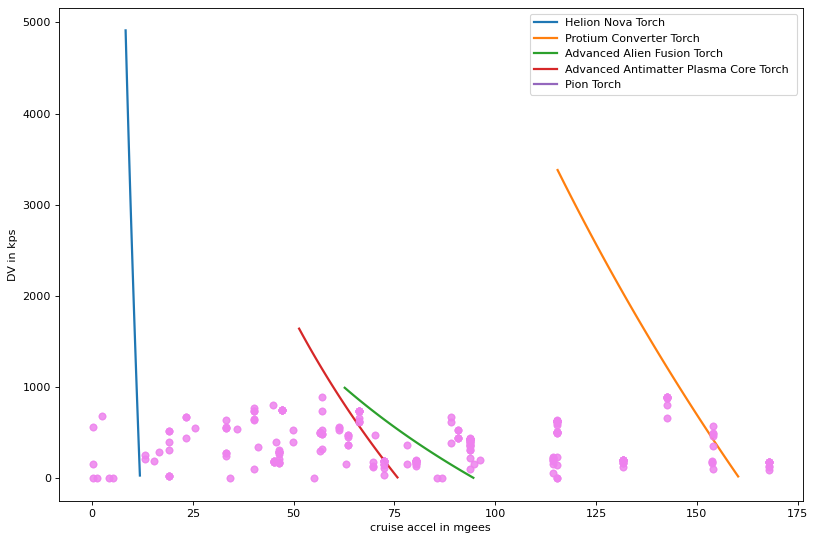

In [ ]:
aliens['dv_share'] = aliens['dv_current']/aliens['dv_max']
non_stat = aliens.loc[aliens['dv_share']<0.95]

figure(figsize=(12, 8), dpi=80)

ks  = [82,85,88,91,92]
for k in ks:

    ve = drives.loc[k,'EV']*1e3

    prop_cap = drives.loc[k,'tank_cap']
    rb = drives.loc[k,'RP_bins'] - 1
    props = np.unique((10**np.linspace(0,np.log10(200),num=100)).astype(int))
    props = props[props<prop_cap]
    prop_mass = props*100

    m0 = drives.loc[k,'dry_mass'] + prop_mass
    mf = drives.loc[k,'dry_mass']
    ve = drives.loc[k,'EV']

    cru_a = drives.loc[k,'thrust'] / (m0) / 9.8
    DV = ve * np.log(m0 / mf)
    # print(drives.loc[k,'name'], DV[-1], cru_a[-1])

    plt.plot(cru_a, DV, label = drives.loc[k,'name'],lw=2)
    plt.plot(non_stat['cruise_accel']*1000/9.8, non_stat['dv_current'], 'o', c='violet', alpha=0.3)


plt.legend(loc='best')

plt.xlabel('cruise accel in mgees')
plt.ylabel('DV in kps')

On a graph above we simply display an example DV and cruise accel in milli-g's for 5 example drives (see the legend) and for alien ships (pink dots). As you can see, alien ships are fairly evenly distributed by accel, but rarely if ever exceed 1000 DV.

In [264]:
def get_pursuit_matrix(a_hum, dv_hum, a_ayy, dv_ayy, D=2e8):
    aH = a_hum[:, None]
    dvH = dv_hum[:, None]
    aA = a_ayy[None, :]
    dvA = dv_ayy[None, :]

    hum_faster = aH > aA
    ayy_faster = aH < aA

    a_min = np.minimum(aH, aA)
    a_max = np.maximum(aH, aA)

    dv_need = a_min * np.sqrt(2.0 * D / (a_max - a_min))
  
    cond1 = hum_faster & (dvH > dv_need) # humans faster -> check hum dv
    cond2 = ayy_faster & (dvA < dv_need) # ayy faster -> check ayy dv

    return cond1 | cond2

This function is how the game calculates the outcome of the pursuit. Well, almost -- it actually calculates the DV required for the chase, and then checks if you have enough. And it also calculates the initial separation as x200 the max weapon range of a given fleet -- so it can reach up to **240000 kilometers**, if you're facing an Alien capital. I put it to 200k km, as a tradeoff.

My modification makes the chase non-symmetrical (the original function is), and also spits the result in a matrix form to account for all the pairs.

Courtesy of user **@fiora** from the official Discord.

Minimag Orion  68370.53281159209 0.0256784642039244
Advanced Minimag Orion  115228.1672370112 0.07479780401127203
Orion Drive  44723.758804555895 0.8053510746806077
Advanced Orion Drive  93978.76776279509 0.8988225424693652
Neutron Flux Lantern  26671.748865584956 3.573668297787685
Neutron Flux Torch  152263.86702027277 2.2274974565834333
Triton Polywell Drive  271161.262815588 0.034507849430711786
Antimatter Plasma Core Torch  379347.5672531918 0.384728779622546


Text(0, 0.5, '% of Ayy ships we catch')

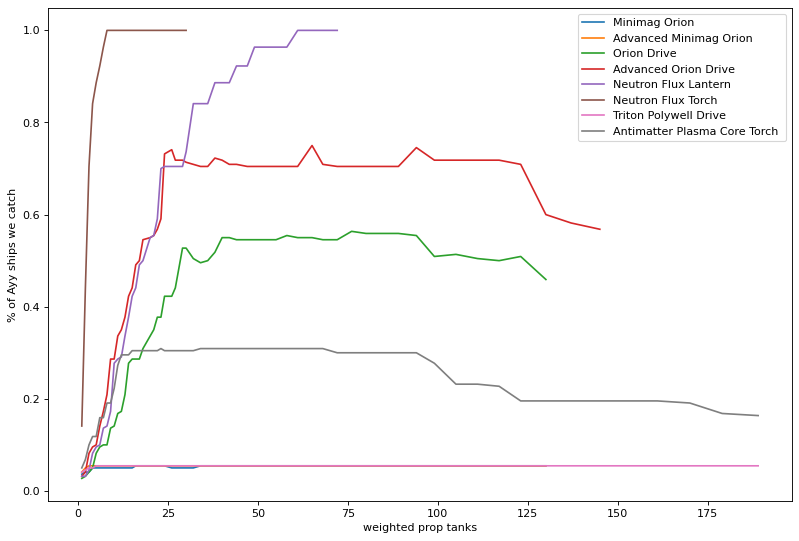

In [267]:
figure(figsize=(12, 8), dpi=80)

ks  = [56,57,58,59,51,52,70,90]
for k in ks:

    ve = drives.loc[k,'EV']*1e3

    prop_cap = drives.loc[k,'tank_cap']
    rb = drives.loc[k,'RP_bins'] - 1
    props = np.unique((10**np.linspace(0,np.log10(200),num=100)).astype(int))
    props = props[props<prop_cap]
    prop_mass = props*100

    m0 = drives.loc[k,'dry_mass'] + prop_mass
    mf = drives.loc[k,'dry_mass']
    ve = drives.loc[k,'EV']

    cru_a = drives.loc[k,'thrust'] / (m0) / 1000
    DV = ve * np.log(m0 / mf) * 1000
    print(drives.loc[k,'name'], DV[-1], cru_a[-1])

    pursue = get_pursuit_matrix(cru_a, DV, non_stat['cruise_accel'].values, non_stat['dv_current'].values*1000)

    plt.plot(props, np.mean(pursue, axis=1), label = drives.loc[k,'name'])
    # plt.plot(cru_a, DV, label = drives.loc[k,'name'])
    # plt.plot(non_stat['cruise_accel'], non_stat['dv_current']*1000, 'o')


plt.legend(loc='best')
 
plt.xlabel('weighted prop tanks')
plt.ylabel('% of Ayy ships we catch')


Here we test the results of how our function works: we calculate the **Mean % share of alien ships that we can catch**, based on our given values of DV and cruise accel, that we get from the given propellant tanks.\
And then we plot that against **Weighted propellant tanks** (same idea as in the case with velocities)

(as before, the cap for propellant tanks is limited by the game stage)

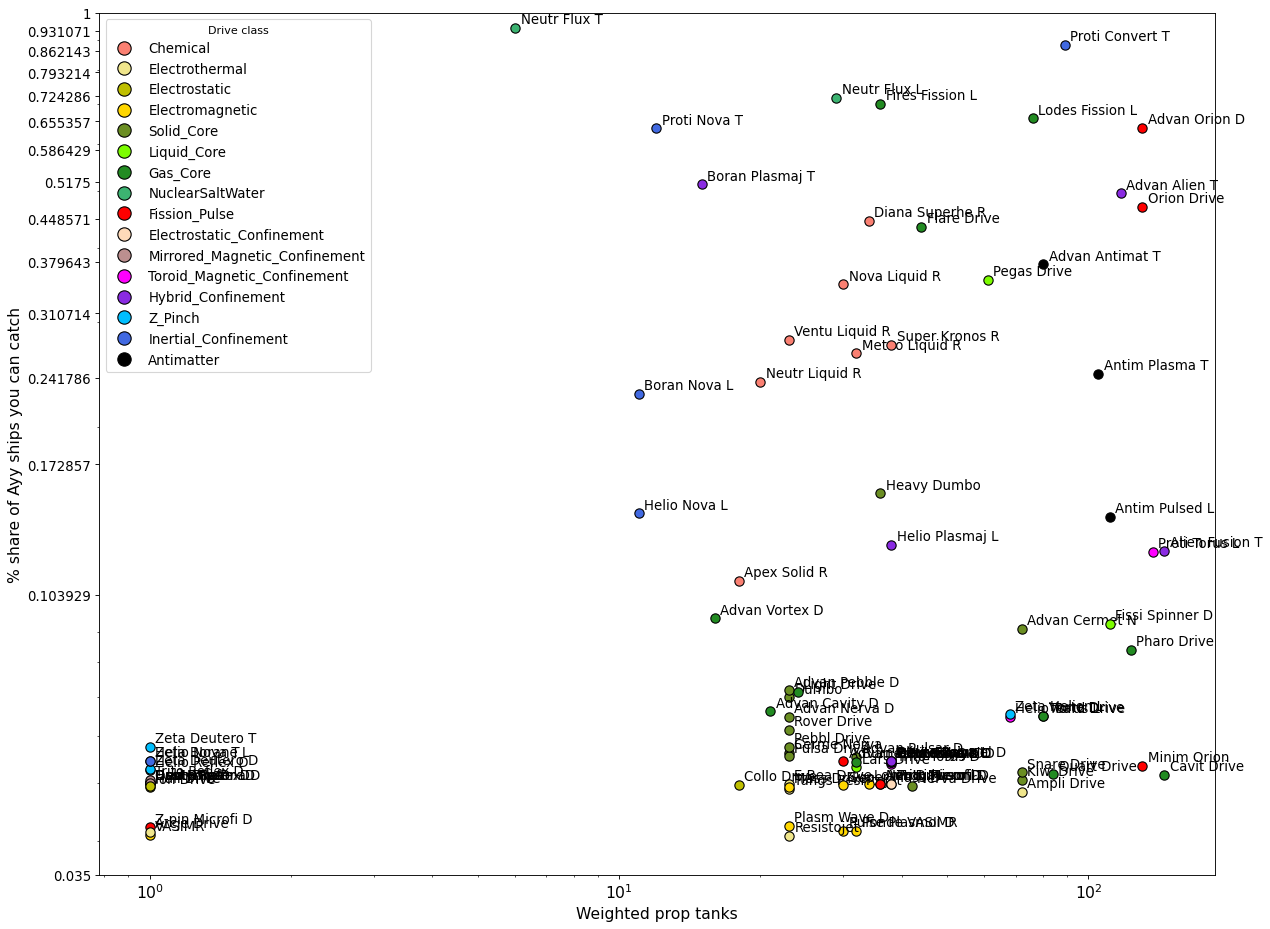

In [270]:
ks = drives.index

pursue = np.zeros(len(drives))
cost_p = np.zeros(len(drives))

classes = drives['class'].unique()
cmap = ['salmon', 'khaki', 'y', 'gold', 'olivedrab','lawngreen','forestgreen','mediumseagreen', 'r',
          'peachpuff', 'rosybrown', 'magenta','blueviolet','deepskyblue','royalblue','k']
color_map = {c: cmap[i] for i, c in enumerate(classes)}

fig, ax = plt.subplots(figsize=(18, 14), dpi=80)

for k in ks:

    ve = drives.loc[k,'EV']*1e3
    
    prop_cap = drives.loc[k,'tank_cap']
    rb = drives.loc[k,'RP_bins'] - 1
    props = np.unique((10**np.linspace(0,np.log10(200),num=100)).astype(int))
    props = props[props<prop_cap]
    prop_mass = props*100
    if len(props)<1:
        continue

    m0 = drives.loc[k,'dry_mass'] + prop_mass
    mf = drives.loc[k,'dry_mass']
    ve = drives.loc[k,'EV']

    cru_a = drives.loc[k,'thrust'] / (m0) / 1000
    DV = ve * np.log(m0 / mf) * 1000
    # print(drives.loc[k,'name'], DV[-1], cru_a[-1])

    pursue_matrix = get_pursuit_matrix(cru_a, DV, non_stat['cruise_accel'].values, non_stat['dv_current'].values*1000)
    mean_pur = np.mean(pursue_matrix, axis=1)
    pursue[k] = np.trapz(mean_pur, props)/(max(props)-min(props)) # expected value for pursue prob (integral of mean_p divided by props range)
    cost_p[k] = props[np.argsort(np.abs(mean_pur-pursue[k]))][0] # the number of tanks, required for expected pursue prob

    # color by drive class
    cls = drives.loc[k,'class'] if pd.notna(drives.loc[k,'class']) else 'Unknown'
    color = color_map.get(cls, 'k')

    # shortened label
    full_name = str(drives.loc[k,'name'])
    if len(full_name.split()) == 1:
        short = full_name.split()[0][:10]
    elif len(full_name.split()) == 2:
        short = full_name.split()[0][:5] + ' ' + full_name.split()[1][:10]
    else:
        short = full_name.split()[0][:5] + ' ' + full_name.split()[1][:7] + ' ' + full_name.split()[-1][:1]
        

    ax.scatter(cost_p[k],
               pursue[k], c=[color], s=70, edgecolors='k', zorder=3)
    ax.annotate(short, xy=(cost_p[k],
                           pursue[k]),
                xytext=(5,4), textcoords='offset points', fontsize=12)

# legend for classes
from matplotlib.lines import Line2D
handles = [Line2D([0],[0], marker='o', color='w', label=c,
                  markerfacecolor=color_map[c], markersize=12, markeredgecolor='k') for c in classes]
ax.legend(handles=handles, loc='best', title='Drive class', fontsize=12)

ax.set_ylim(0.035,1.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Weighted prop tanks', fontsize=14)
ax.set_ylabel('% share of Ayy ships you can catch', fontsize=14)

ax = plt.gca()
numticks = 15
ax.yaxis.set_major_locator(mticker.LinearLocator(numticks))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%g'))
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12)


And here is our second major chunk of metrics (the remaining 4th and 5th).

Here we do the same trick with integrating, as before:
1.  we calculate the **intercept chance, averaged by all the tanks, available for the given drive**
2. as well as we calculate the **Weighted prop tanks**, which give you this particular chance

And we do that for all the drives, and then plot that.

# Part 6: Final Rating

In [29]:
drives['veloc'] = veloc
drives['pursue'] = pursue
drives['range'] = rangeR - 1 # 1 is subtracted, since 1 AU is just Earth, and we're checking if drive can go beyond that
drives['inv_cost'] = 1 / (cost_v +cost_p ) / drives['price_tank']

Those are our key metrics

In [30]:
def log_norm(a):
    a = a.copy()
    mask = a>0
    b = a[mask]
    b = np.log10(b) - np.log10(min(b))
    b = b/(max(b)-min(b))*100
    a[mask] = b
    return a

With this function we'll create a normalized logarithmic rating for each category. I.e. velocities will be ranked from 0 to 100, then intercept chances, and inverse costs

Log is needed, IMO, because the game's progress scales more or less exponentially in most regards.

(array([ 1.,  0.,  0.,  0.,  3.,  4., 15., 35., 35.,  3.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

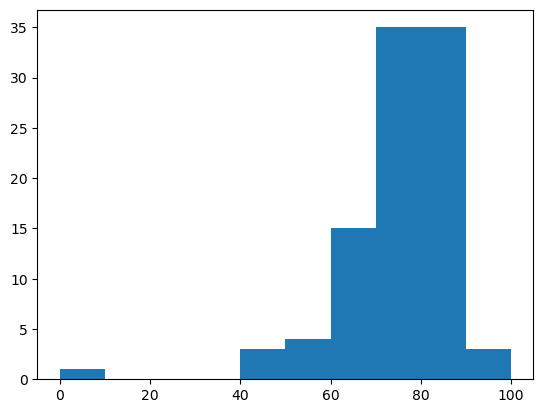

In [31]:
plt.hist(log_norm(drives['inv_cost']))

If we check the distributions, we'll immediately notice a HUGE inverse price outlier -- which is Pion Torch, naturally. By being ridiculously low itself, it shifts everything up significantly. We better just drop it.

In [32]:
display(drives.loc[drives['name'].str.contains('Pion'),'inv_cost'])
drives.drop(drives[drives['name'].str.contains('Pion')].index, inplace=True)

92    0.000001
Name: inv_cost, dtype: float64

In [33]:
drives['rating'] = (log_norm(drives['veloc']) + log_norm(drives['pursue']) + log_norm(drives['inv_cost']))/3 * drives['range']/100
drives['rating'].fillna(1, inplace=True)

drives['rating'] = drives['rating']/(drives['rating'].max())*100
# 

So, after that we can simply add our individual metric ranges together:
- Averaged intercept chances
- Averaged speed across available orbits
- Inverted sum of propellant tanks which we spend for both intercept and for transfer (you're spending them for the same ship, after all). And then also divide by the tank price, weighted by rarity.

And then multiply by maximum range rating, divided by 100. So it's essentially a penalty for weak drives that can not go beyond Earth -- without that term Nova Liquid Rocket would be one of the best drives.

And finally, we normalize the ratings to 0-100 range again for convenience

In [34]:
drives[['name','rating','RP_raw']].sort_values(by='rating', ascending=False).head(10)

,name,rating,RP_raw
85,Protium Converter Torch,100.000000,3370775
88,Advanced Alien Fusion Torch,90.520732,-2
84,Protium Nova Torch,81.376288,1405775
91,Advanced Antimatter Plasma Core Torch,80.403207,1112775
73,Borane Plasmajet Torch,74.401917,1119250
82,Helion Nova Torch,71.818010,1045775
52,Neutron Flux Torch,71.813591,437750
69,Protium Torus Lantern,66.151704,926250
76,Zeta Deuteron Torch,63.948706,1161275
87,Alien Fusion Torch,63.176056,-1


## Final plot: Rating vs Research Points

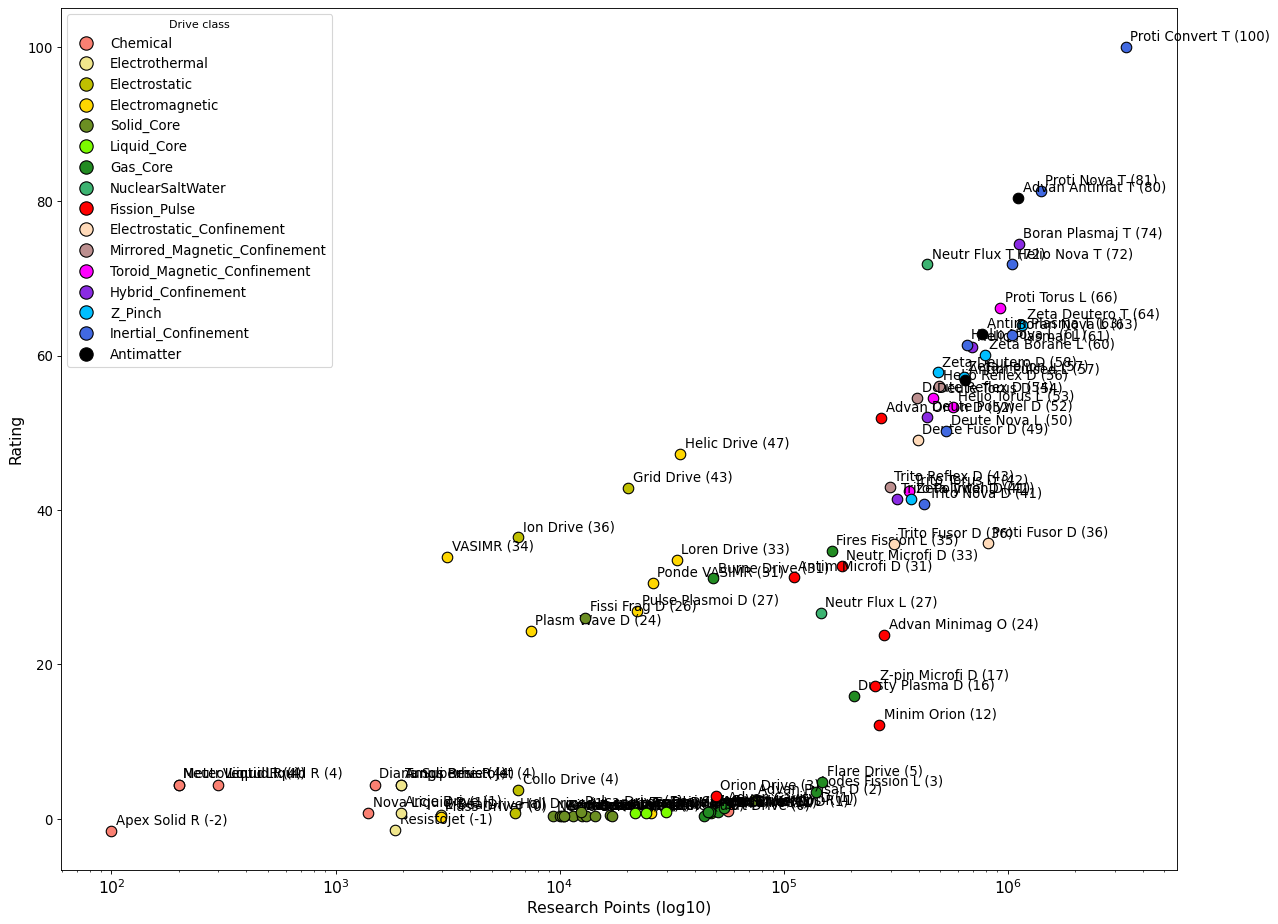

In [35]:
ks = drives.index

classes = drives['class'].unique()
cmap = ['salmon', 'khaki', 'y', 'gold', 'olivedrab','lawngreen','forestgreen','mediumseagreen', 'r',
          'peachpuff', 'rosybrown', 'magenta','blueviolet','deepskyblue','royalblue','k']
color_map = {c: cmap[i] for i, c in enumerate(classes)}

fig, ax = plt.subplots(figsize=(18, 14), dpi=80)

for k in ks:

    # color by drive class
    cls = drives.loc[k,'class'] if pd.notna(drives.loc[k,'class']) else 'Unknown'
    color = color_map.get(cls, 'k')

    # shortened label
    full_name = str(drives.loc[k,'name'])
    if len(full_name.split()) == 1:
        short = full_name.split()[0][:10] + ' (' + str(round(drives.loc[k,'rating'])) + ')'
    elif len(full_name.split()) == 2:
        short = full_name.split()[0][:5] + ' ' + full_name.split()[1][:10] + ' (' + str(round(drives.loc[k,'rating'])) + ')'
    else:
        short = full_name.split()[0][:5] + ' ' + full_name.split()[1][:7] + ' ' + full_name.split()[-1][:1] + ' (' + str(round(drives.loc[k,'rating'])) + ')'

    ax.scatter(drives.loc[k,'RP_raw'],
               drives.loc[k,'rating'], c=[color], s=90, edgecolors='k', zorder=3)
    ax.annotate(short, xy=(drives.loc[k,'RP_raw'],
                           drives.loc[k,'rating']),
                xytext=(4,6), textcoords='offset points', fontsize=12)

# legend for classes
from matplotlib.lines import Line2D
handles = [Line2D([0],[0], marker='o', color='w', label=c,
                  markerfacecolor=color_map[c], markersize=12, markeredgecolor='k') for c in classes]
ax.legend(handles=handles, loc='best', title='Drive class', fontsize=12)

# ax.set_ylim(0.035,1.)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Research Points (log10)', fontsize=14)
ax.set_ylabel('Rating', fontsize=14)

ax = plt.gca()
# # numticks = 15
# # ax.yaxis.set_major_locator(mticker.LinearLocator(numticks))
# # ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%g'))
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12)
